<a href="https://colab.research.google.com/github/Duong123-art/Classification_Regconition/blob/main/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fmin_cg
import scipy.io as si
from scipy.io import loadmat
from scipy.optimize import minimize
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Link Data In Drive To CoLab

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


#Read label file
file_ID = '1XS7kLWPsJyTk1xaU6lIppzFskwszW3lb'
file_name = 'data.mat'
downloaded = drive.CreateFile({'id':file_ID})   # replace the id with id of file you want to access
downloaded.GetContentFile(file_name) 

#Read data train file
file_ID = '1-6kZAn4XFX85hX4cZmp4mWf14XYDWujN'
file_name = 'Train_32x64.csv'
downloaded = drive.CreateFile({'id':file_ID})   # replace the id with id of file you want to access
downloaded.GetContentFile(file_name)

#Read data test file
file_ID = '1iNG4wpzH119FdM2101t3QuNSifSwV5DF'
file_name = 'Test_32x64.csv'
downloaded = drive.CreateFile({'id':file_ID})   # replace the id with id of file you want to access
downloaded.GetContentFile(file_name)

# Load Data


In [ ]:
Train_32x64 = pd.read_csv("Train_32x64.csv", header=None);
X = Train_32x64.fillna(0.)
X = np.array(X)

data = loadmat("data.mat")
# print(data.keys())
y = data['y']

yy = data['y'].flatten()

# replace 10 -> 0 
# re-cast y
y = np.zeros((len(yy), 5))
for ii in range(y.shape[0]):
    y[ii, yy[ii]] = 1

print('\nX:',X.shape, '(without intercept)')
print('y:',y.shape)

m,n = X.shape
print('\nNumber of features (n): %.0f'%(n))
print('Number of training examples (nm): %.0f'%(m))

# weights = loadmat('ex4weights.mat')
# weights.keys()

# theta1, theta2 = weights['Theta1'], weights['Theta2']
# print('\ntheta1 :', theta1.shape)
# print('theta2 :', theta2.shape)

# nn_params = np.concatenate((np.reshape(theta1, theta1.size, order = 'F'),
#                             np.reshape(theta2, theta2.size, order = 'F')))
# print('params :', nn_params.shape)


X: (800, 756) (without intercept)
y: (800, 5)

Number of features (n): 756
Number of training examples (nm): 800


#Display Data

ValueError: ignored

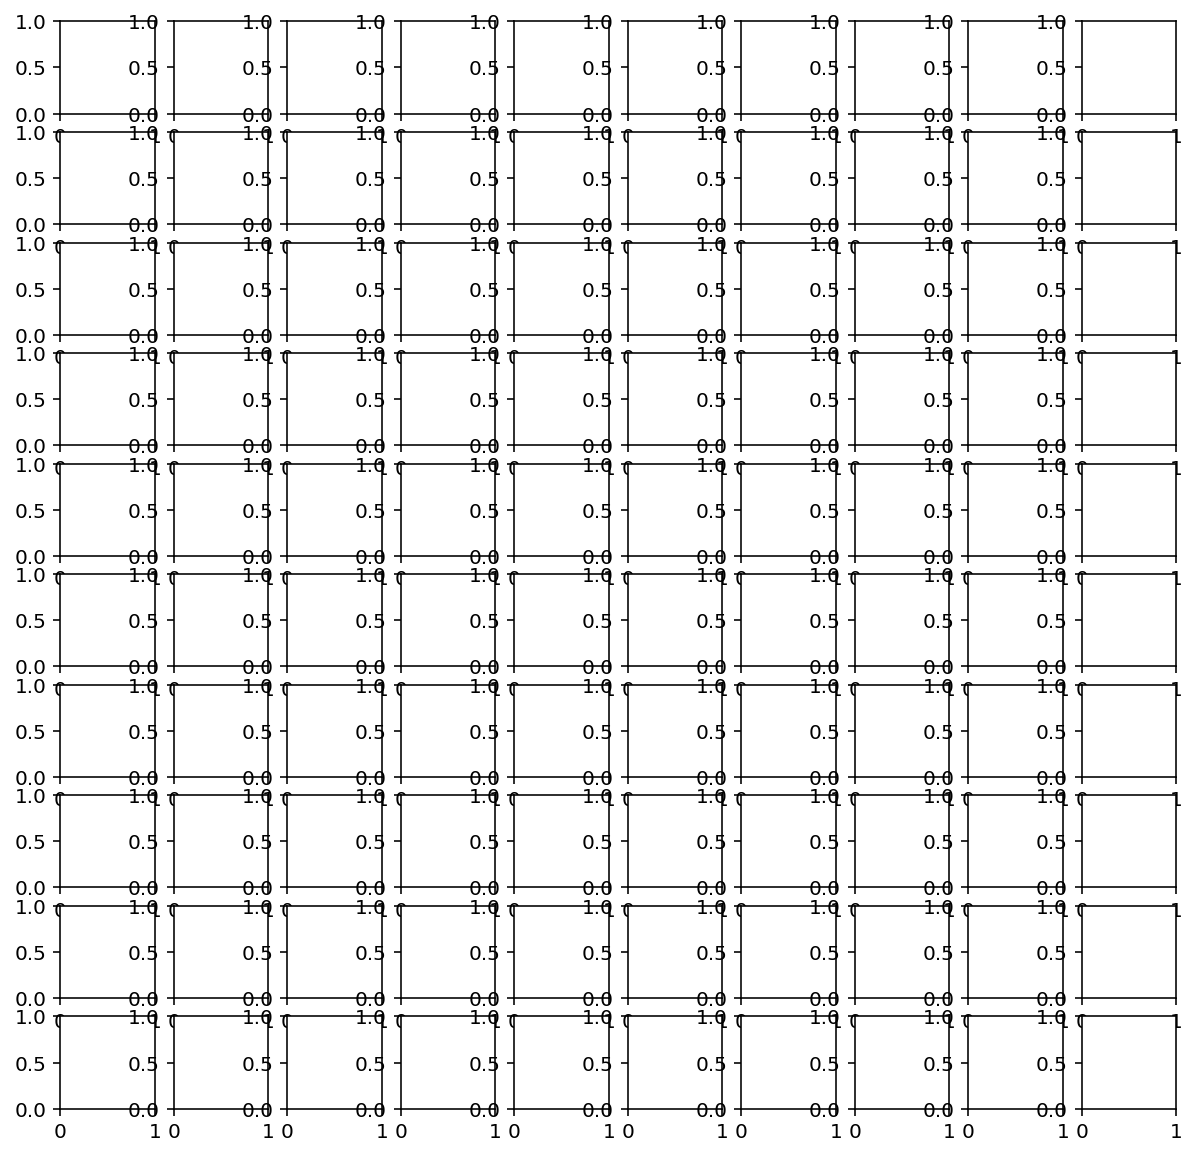

In [ ]:
def displayData(X, nrows = 10, ncols = 10):
    
    # set up array
    fig, axarr = plt.subplots(nrows = nrows, ncols = ncols,
                              figsize = (nrows, ncols))
    
    # loop over randomly drawn numbers
    for ii in range(nrows):
        for jj in range(ncols):
            ind = np.random.randint(X.shape[0])
            tmp = X[ind,:].reshape(20, 20, order = 'F')
            axarr[ii,jj].imshow(tmp, cmap = 'gray_r')
            plt.setp(axarr[ii,jj].get_xticklabels(), visible = False)
            plt.setp(axarr[ii,jj].get_yticklabels(), visible = False)
    
    fig.subplots_adjust(hspace = 0, wspace = 0)
    
displayData(X)

#Signmoid and Sigmoid Gradient Function

At 0 sigmoid gradient is 0.25


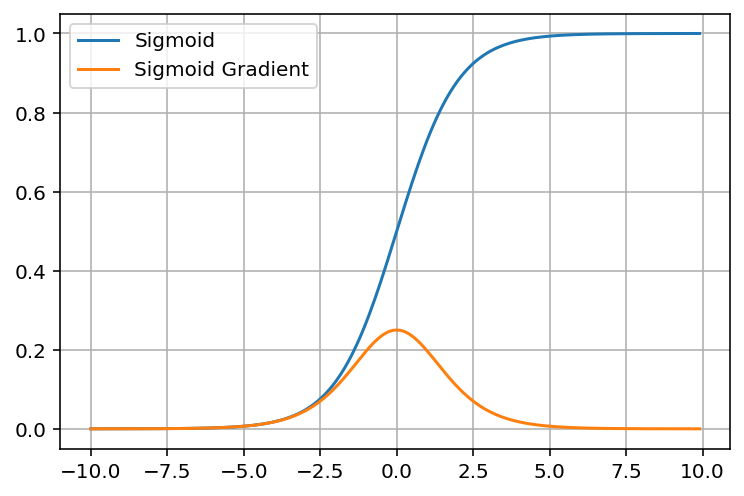

In [ ]:
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return(g)

def sigmoidGradient(z):
    dg = sigmoid(z) * (1 - sigmoid(z))
    return(dg)


Xaxis = np.arange(-10,10, 0.1)

print('At 0 sigmoid gradient is', sigmoidGradient(0))


plt.plot(Xaxis, sigmoid(Xaxis), label = 'Sigmoid')
plt.plot(Xaxis, sigmoidGradient(Xaxis), label = 'Sigmoid Gradient')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
L = 2048 # Input layer size = 400 (20x20 pixels)
input_layer_size = 756 
hidden_layer_size = 15
num_labels = 5
reg = 0.7
#n_training_samples = X.shape[0]
""""
X = input layer
y = classes

nn_params : 1D vector with parameters for neural net
input_layer_size: 400
hidden_layer_size: 25
num_labels: number of labels or size of final layer
X: input data
y: classes
reg: regularization coefficient


"""
#Neural Network Cost Function
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, reg):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params (array). The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size (int). Number of features for the input layer. 
    
    hidden_layer_size (int). Number of hidden units in the second layer.
    
    num_labels (int). Total number of labels, or equivalently number of units in output layer. 
    
    X : (array).Input dataset. A matrix of shape (m x input_layer_size).
    
    y : (array). Dataset labels. A vector of shape (m,).
    
    reg : (float)Regularization parameter.
 
    Returns
    -------
    J (float) The computed value for the cost function at the current weight values.
    
    grad (array) An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    """
    
    """
    - Part 1: Feedforward the neural network and return the cost in the 
              variable J. After implementing Part 1, you can verify that your
              cost function computation is correct by verifying the cost
              computed in the following cell.
    """

    # tolerance for sigmoid function.
    # i.e., 1-htheta cannot be less than 1e-15
    # this fixes loss of precision errors
    eps = 1e-15
    
    # sizes
    m, n = X.shape
    
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size +1)],
                        (hidden_layer_size, input_layer_size + 1), order = 'F')
    
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                        (num_labels, (hidden_layer_size + 1)), order = 'F')
    
    # add ones to X data matrix
    X = np.hstack((np.ones((m, 1)), X))
    
    # hidden layer
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)
    
    #add bias unit to a2
    a2 = np.hstack((np.ones((a2.shape[0],1)), a2))

    # output layer
    z3 = np.dot(a2, Theta2.T)
    htheta = sigmoid(z3)
    
    # cost function
    J = - 1 / m * np.sum((np.sum(np.log(htheta) * y) + np.sum(np.log(1 - htheta + eps) * (1 - y))\
                          - reg / 2 * (np.sum(Theta1[:, 1:]**2) + np.sum(Theta2[:, 1:] ** 2)))) 
    
    """
    Part 2: Implement the backpropagation algorithm to compute the gradients
              Theta1_grad and Theta2_grad. You should return the partial derivatives of
              the cost function with respect to Theta1 and Theta2 in Theta1_grad and
              Theta2_grad, respectively. 
    """
        
    # back prop
    delta3 = htheta - y
    delta2 = np.dot(delta3, Theta2)[:,1:] * sigmoidGradient(z2)
    #print np.dot(htheta, Theta2)[:,1:].shape, sigmoidGradient(z2).shape
        
    Delta1 = np.dot(delta2.T, X)
    Delta2 = np.dot(delta3.T, a2)
    
    Theta1_grad = 1 / m * Delta1
    Theta2_grad = 1 / m * Delta2
    
    # regularization
    Theta1_grad[:,1:] += reg / m * Theta1[:,1:]
    Theta2_grad[:,1:] += reg / m * Theta2[:,1:]
                
    # pack gradient
    grad = np.concatenate((np.reshape(Theta1_grad, Theta1_grad.size, order='F'),
                            np.reshape(Theta2_grad, Theta2_grad.size, order='F')))
    

    return(J, grad)

# J, grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
#                    num_labels, X, y, reg - 0)
# print('Cost at parameters (loaded from ex4weights): %.6f ' % J)


###Gradient Checking & Random Initialisation

In [ ]:
def randInitializeWeights(L_in, L_out):
    epsilon_int = 0.12;
    eps_rand = np.random.rand(L_out, 1 +  L_in) * 2 * epsilon_int - epsilon_int
    return(eps_rand)
    
def computeNumericalGradient(J, theta):
    
    numgrad = np.zeros(len(theta))
    perturb = np.zeros(len(theta))
    e = 1e-4
    for p in range(len(theta)):
        
        # Set perturbarion vactor
        perturb[p] = e
        loss1 = J(theta - perturb)
        loss2 = J(theta + perturb)
        
        # compute numerical gradient
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
        
    return numgrad

# def checkNNGradients(reg = 0):
    
#     input_layer_size = 3
#     hidden_layer_size = 5
#     num_labels = 3
#     m = 5
    
#     # generate some random test data
#     Theta1 = randInitializeWeights(hidden_layer_size, input_layer_size)
#     Theta2 = randInitializeWeights(num_labels, hidden_layer_size)
    
#     X = randInitializeWeights(input_layer_size - 1, m)
#     yy = 1 + np.mod(np.arange(m), num_labels)
    
#     # re-cast y
#     y = np.zeros((len(yy), num_labels))
#     for ii in range(y.shape[0]):
#         y[ii, yy[ii] - 1] = 1
        
#     # unroll parameters
#     nn_params = np.concatenate((np.reshape(Theta1, Theta1.size, order = 'F'),
#                             np.reshape(Theta2, Theta2.size, order = 'F')))
    
#     # cost function
#     costFunc = lambda p: nnCostFunction(p, input_layer_size,
#                          hidden_layer_size, num_labels, 
#                          X, y, reg)[0]
    
#     cost, grad = nnCostFunction(nn_params, input_layer_size,
#                          hidden_layer_size, num_labels, 
#                          X, y, reg)
#     numgrad = computeNumericalGradient(costFunc, nn_params)
    
#     cnt = 0
#     print('Gradient Checking for Lambda = %.1f'%(reg))
#     print('Count \t\t title \t\t\t title \t\t\tDifference')
#     for g, ng in zip(grad, numgrad):
#         print('%.0f. \t %.15f \t  %.15f \t %.15f'%(cnt, g, ng, np.abs(g - ng) / ng))
#         cnt += 1
#     print('\n\n')
    
# checkNNGradients()
# checkNNGradients(3)
# checkNNGradients(5)

###Regularisation

In [ ]:
reg = 0
nnCostFunction(nn_params, input_layer_size, 25, 10, X, y, reg)[0]

#print('For Lambda = %.0f, \n\tCost  = %.2f \n\t Theta1_grad = %.2f \n\t Theta2_grad = %.2f' %(Lambda, J, theta1_grad, theta2_grad ) )


# Regularization parameter = 1]
reg = 1
nnCostFunction(nn_params, input_layer_size, 25, 10, X, y, reg)[0]


[sigmoidGradient(z) for z in [-1, -0.5, 0, 0.5, 1]]

NameError: ignored

#Learning parameter

In [ ]:
def predict(Theta1, Theta2, X):
    
    # sizes
    m, n = X.shape
    num_labels = Theta2.shape[0]
    
    # add ones to X data matrix
    X = np.hstack((np.ones((m, 1)), X))
        
    # hidden layer
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)

    #add bias unit to a2
    a2 = np.hstack((np.ones((a2.shape[0],1)), a2))

    # output layer
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)

    p = np.argmax(a3, axis=1)
    
    return p


reg = 1
maxiter = 400

# function prototypes
cost = lambda x: nnCostFunction(x, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, reg)[0]

grad = lambda x: nnCostFunction(x, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, reg)[1]

# initialize parameters
init_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
init_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

print(init_Theta1.shape)
print(init_Theta2.shape)

init_nn_params = np.concatenate((np.reshape(init_Theta1, init_Theta1.size, order = 'F'),
                            np.reshape(init_Theta2, init_Theta2.size, order = 'F')))

# run minimization
nn_params = fmin_cg(cost, init_nn_params, fprime=grad, maxiter=maxiter, disp=False)


# Reshape nn_params back into the parameters for Theta
# Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
#                     (hidden_layer_size, input_layer_size + 1), order = 'F')
# Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
#                     (num_labels, (hidden_layer_size + 1)), order = 'F')

# p = predict(Theta1, Theta2, X)

# print('Training set Accuracy: %2.2f percent' % (np.mean(p == yy) * 100))

(15, 757)
(5, 16)


#Run Test Data


In [ ]:
mask = np.array([[i]*20 for i in range(5)])
y_test = mask.flatten()

Test_32x64 = pd.read_csv("Test_32x64.csv", header=None);
X_test = Test_32x64.fillna(0.)
X_test = np.array(X_test)

p_test = predict(Theta1, Theta2, X_test)
print("Predict: " , p_test)
print("Label:   " , y_test)
print('Testing set Accuracy: %2.2f percent' % (np.mean(p_test == y_test) * 100))

Predict:  [0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 2 0 0 0 1 2 2 1 1 2 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 0 0 0 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Label:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Testing set Accuracy: 89.00 percent


###Plot Result



[160, 160, 161, 159, 160]



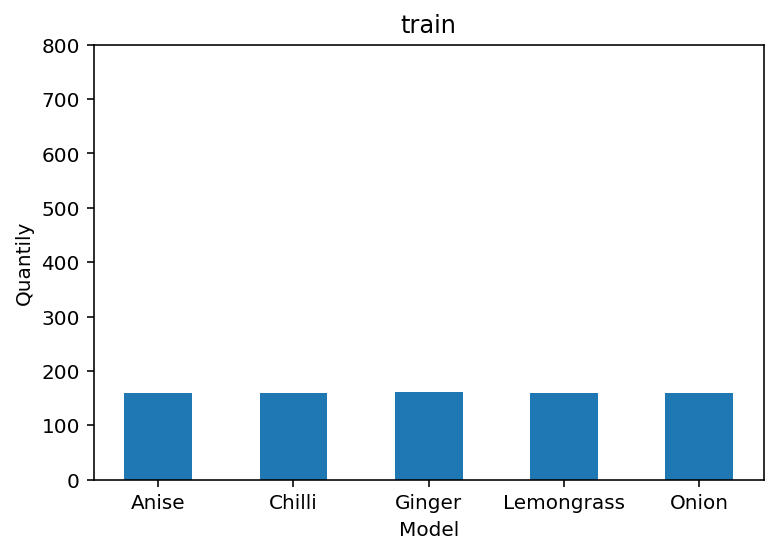

In [ ]:
#displayData(Theta1[:,1:], nrows = 5, ncols = 5)
lot=[0,0,0,0,0]
for i in range(800):
  if(p[i]==4):
    lot[0]+=1
  elif(p[i]==0):
    lot[1]+=1
  elif(p[i]==1):
    lot[2]+=1
  elif(p[i]==2):
    lot[3]+=1
  elif(p[i]==3):
    lot[4]+=1
print(lot)
print()

count={'Anise':lot[0],'Chilli': lot[1], 'Ginger':lot[2],'Lemongrass':lot[3],'Onion':lot[4]}

plt.bar(range(len(count)),count.values(),align='center',width=0.5)
plt.xticks(range(len(count)),count.keys())
plt.ylim(0,800)
plt.title('train')
plt.xlabel('Model')
plt.ylabel('Quantily')

plt.show()




